The task is to predict rain in australia using machine learning tools and the weatherAUS.csv dataset from Kaggle

Step 1: Importing spark session and initializing spark

In [1]:
#Importing the libraries
#!pip install matplotlib
#!pip install seaborn
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
from pyspark.sql.functions import col,avg
from pyspark.sql.functions import when,lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
import seaborn as sns
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
# This line is to avoid error that is thrown if there is an existing spark context, 
sc = SparkContext.getOrCreate()

# local[4]: run Spark locally with 4 logical cores 

# If there is no existing spark context, new context is created
if (sc is None):
    sc = SparkContext(master="local[4]", appName="Assignment2")
spark = SparkSession(sparkContext=sc)

Step 2: Loading the dataset and Printing the schema and total number of entries

In [3]:
df_weather = spark.read.csv("weatherAUS.csv", inferSchema = True, header= True)

In [4]:
df_weather.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [5]:
# Calculating the total number of entries in the dataframe
df_weather.count()

142193

### Part B: Data Cleaning and Processing

Step 3: Deleting columns from the dataset
The following columns have to be deleted to improve the efficiency of our model:
1. Date
2. Location
3. Evaporation
4. Sunshine
5. Cloud9am
6. Cloud3pm
7. Temp9am
8. Temp3pm


In [6]:
df_weather = df_weather.drop('Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm' )

In [7]:
df_weather.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



Step 4: Print the number of missing data in each column

In [8]:

for c in df_weather.columns:
    print(c, df_weather.filter(col(c)== "NA").count())
    

MinTemp 637
MaxTemp 322
Rainfall 1406
WindGustDir 9330
WindGustSpeed 9270
WindDir9am 10013
WindDir3pm 3778
WindSpeed9am 1348
WindSpeed3pm 2630
Humidity9am 1774
Humidity3pm 3610
Pressure9am 14014
Pressure3pm 13981
RainToday 1406
RainTomorrow 0


Step 5: Fill missing data with average value(numeric data) and maximum occurence(non numeric data)

a)Finding the columns with numeric data and fillling it with average value
The numeric columns are:

1) MinTemp

2) MaxTemp

3) Rainfall

4) WindGustSpeed

5) WindSpeed9am

6) WindSpeed3pm

7) Humidity9am

8) Humidity3pm

9) Pressure9am

10) Pressure3pm

In [9]:

columns = [ "MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm"  ]
for c in columns:
    k = df_weather.agg(avg(col(c)).alias(c)).collect()[0][c] #getting the average value
    print("Average value of", c, "is", k)
    # replacing NA with the average value
    df_weather = df_weather.withColumn(c ,when(df_weather[c] == "NA", lit(k)).otherwise(df_weather[c]))
    

Average value of MinTemp is 12.186399728729311
Average value of MaxTemp is 23.2267841912725
Average value of Rainfall is 2.3499740743107442
Average value of WindGustSpeed is 39.98429165757619
Average value of WindSpeed9am is 14.001988000994
Average value of WindSpeed3pm is 18.63757586179718
Average value of Humidity9am is 68.8438103105705
Average value of Humidity3pm is 51.482606091656265
Average value of Pressure9am is 1017.6537584159615
Average value of Pressure3pm is 1015.2582035378894


b) Finding the columns with  non numeric data and filling with the most frequent value. The non numeric columns are:

1) WindGustDir

2) WindDir9am

3) WindDir3pm

4) RainToday

5) RainTomorrow

In [10]:
columns = ["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow"]
for c in columns:
    freq = df_weather.groupBy(c).count() # getting the frequency for each distinct items in the column
    # sorting the frequency of the items in descending order and taking the top most value as most frequent word
    max_freq = freq.sort("count", ascending=False).collect()[0][c] 
    print("Most frequent item of", c, "is", max_freq)
    # Replacing NA with the most frequent item in the column
    df_weather = df_weather.withColumn(c ,when(df_weather[c] == "NA", lit(max_freq)).otherwise(df_weather[c]))

Most frequent item of WindGustDir is W
Most frequent item of WindDir9am is N
Most frequent item of WindDir3pm is SE
Most frequent item of RainToday is No
Most frequent item of RainTomorrow is No


In [11]:
# To check for NA in each column
for c in df_weather.columns:
    print(c, df_weather.filter(col(c)== "NA").count())
    

MinTemp 0
MaxTemp 0
Rainfall 0
WindGustDir 0
WindGustSpeed 0
WindDir9am 0
WindDir3pm 0
WindSpeed9am 0
WindSpeed3pm 0
Humidity9am 0
Humidity3pm 0
Pressure9am 0
Pressure3pm 0
RainToday 0
RainTomorrow 0


Step 6: Data Transformation

1) Converting the numeric value columns into double data type instead of string data type

2) Converting the non numeric column into numbers using the StringIndexer

In [12]:
df_weather.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



For numeric data

In [13]:
columns = [ "MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm"  ]
count = 0
for c in columns:
    df_weather = df_weather.withColumn(c, df_weather[c].cast("double"))
    count+=1
print(count)

10


For non numeric columns

In [14]:
non_numeric_columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
# Declares the stages variable to output as output.
stages = []

In [15]:
for n in non_numeric_columns:
    # a numeric value is given to each category
    stringIndexer = StringIndexer(inputCol = n, outputCol = n + 'Index')
    stages += [stringIndexer]

Step 7: Create the feature vector and divide the dataset

In [16]:
non_numeric_columns1 = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

string_label = StringIndexer(inputCol = 'RainTomorrow', outputCol = 'label')
stages += [string_label]
numeric_columns = [ "MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm"  ]
assemblerInputs = [c + "Index" for c in non_numeric_columns1] + numeric_columns

In [17]:
assemblerInputs

['WindGustDirIndex',
 'WindDir9amIndex',
 'WindDir3pmIndex',
 'RainTodayIndex',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm']

In [18]:
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")
stages += [assembler]


In [19]:
columns1 = df_weather.columns

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_weather)
weather_model = pipelineModel.transform(df_weather)
selectedCols = ['label', 'features'] + columns1
weather_model = weather_model.select(selectedCols)

weather_model.printSchema()




root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [20]:
# Dividing the data into train and test sets
train, test = weather_model.randomSplit([0.7, 0.3], seed = 2018)

In [21]:
print(train.count())
print(test.count())

99626
42567


### Part C : Apply Machine Learning Algorithms

Step 8: Apply Machine Learning classification algorithms
        
        Compare their accuracy
        
        Plot the accuracy as a bar graph

The BinaryClassificationEvaluator is used to evaluate the models.


Decision tree classifier

In [22]:
# DecisionTreeClassifier gets the number of nodes and the tree depth in the model and stores it in dt.
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 25)
dtModel = dt.fit(train)

#transform() method is used to predict the test data
predictions_dt = dtModel.transform(test)

predictions_dt.select('prediction','RainTomorrow', 'label' ).show(10)


+----------+------------+-----+
|prediction|RainTomorrow|label|
+----------+------------+-----+
|       0.0|          No|  0.0|
|       1.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
+----------+------------+-----+
only showing top 10 rows



Accuracy for Decision Tree classifier

In [23]:
dt_evaluator = BinaryClassificationEvaluator()
accuracy_dt = dt_evaluator.evaluate(predictions_dt)
print("Test Area Under ROC: " + str(dt_evaluator.evaluate(predictions_dt, {dt_evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.7128143774125967


Random Forest Classifier

In [24]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

rfmodel = rf.fit(train)
#transform() method is used to predict the test data
predictions_rf = rfmodel.transform(test)

predictions_rf.select('prediction','RainTomorrow', 'label').show(10)



+----------+------------+-----+
|prediction|RainTomorrow|label|
+----------+------------+-----+
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
+----------+------------+-----+
only showing top 10 rows



Accuracy of Random Forest

In [25]:
rf_evaluator = BinaryClassificationEvaluator()
accuracy_rf = rf_evaluator.evaluate(predictions_rf)
print("Test Area Under ROC: " + str(rf_evaluator.evaluate(predictions_rf, {rf_evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.8186051802082278


Logistic Regression

In [26]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label',    maxIter=10)
lrModel = lr.fit(train)
predictions_lr = lrModel.transform(test)

predictions_lr.select('prediction','RainTomorrow', 'label' ).show(10)


+----------+------------+-----+
|prediction|RainTomorrow|label|
+----------+------------+-----+
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
+----------+------------+-----+
only showing top 10 rows



Accuracy for Logistic Regression

In [27]:
lr_evaluator = BinaryClassificationEvaluator()
accuracy_lr = lr_evaluator.evaluate(predictions_lr)
print("Test Area Under ROC: " + str(lr_evaluator.evaluate(predictions_lr, {lr_evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.8128918210724156


Gradient boosted tree classifier

In [28]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions_gbt = gbtModel.transform(test)
predictions_gbt.select('prediction','RainTomorrow', 'label').show(10)
 


+----------+------------+-----+
|prediction|RainTomorrow|label|
+----------+------------+-----+
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
|       0.0|          No|  0.0|
+----------+------------+-----+
only showing top 10 rows



In [29]:
#Use the #BinaryClassificationEvaluator method to evaluate the accuracy of the model
gbt_evaluator = BinaryClassificationEvaluator()
accuracy_gbt = gbt_evaluator.evaluate(predictions_gbt)
print("Test Area Under ROC: " + str(gbt_evaluator.evaluate(predictions_gbt, {gbt_evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.8556724818957474


Bar Chart

In [30]:
# The accuracies are:
print("Accuracy of Decision Tree classifier is:", accuracy_dt)
print("Accuracy of Random Forest classifier is:", accuracy_rf)
print("Accuracy of logistic regression is classifier:", accuracy_lr)
print("Accuracy of Gradient boosted tree classifier is:", accuracy_gbt) 

Accuracy of Decision Tree classifier is: 0.7128143774125968
Accuracy of Random Forest classifier is: 0.8186051802082277
Accuracy of logistic regression is classifier: 0.8128918210724098
Accuracy of Gradient boosted tree classifier is: 0.8556724818957463


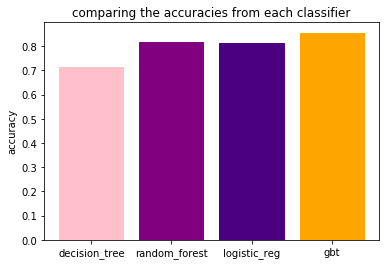

In [31]:
x_axis = ["decision_tree", "random_forest", "logistic_reg", "gbt"]
y_axis = [accuracy_dt, accuracy_rf, accuracy_lr, accuracy_gbt]
barlist = plt.bar(x_axis,y_axis)
plt.title("comparing the accuracies from each classifier")
plt.ylabel("accuracy")
barlist[0].set_color('pink')
barlist[1].set_color('purple')
barlist[2].set_color('indigo')
barlist[3].set_color('orange')
plt.show()

Step 9: Calculate confusion matrix,
        precision,
        recall,
        F1 score


Confusion matrix gives us the summary of prediction results and based on these results the other performance metrics are calculated.
Confusion matrix consists of the following:
1) True Positives
2) True Negatives
3) False Positives
4) False Negatives


From this, we can calculate:

        
1) Accuracy = (True Positive + True Negative)/(True Positive + False Positive + False Negative + True Negative)
In the above steps, accuracy was caculated, which gives the number of correct predictions made by the model out of all kinds of predictions made. 

In the following steps the below measures are calculated so as to evaluate the models better

2) Precision = (True Positive)/(True Positive + False Positive)
It tells us what proportion of the days that were predicted to have rain and actually there was rain on those days.

3) Recall = (True Positive)/(True Positive + False Negative)
It tells us what proportion of rainy days were predicted by the algorithm as rainy days

4) F1 Score = (2*Precision*Recall)/(Precision + Recall)
Its a score that represents both precision and recall
        

Decision tree

Confusion matrix:
[[27630.  5428.]
 [ 4260.  5249.]] 

Overall statistics
Precision = 0.7724058543002795
Recall = 0.7724058543002795
F1 Score = 0.7724058543002795


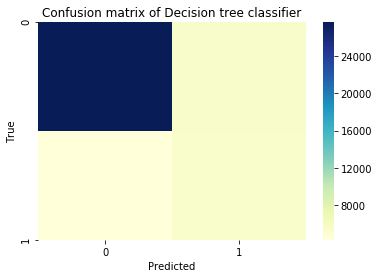

In [32]:
pl_dt = predictions_dt.select(['prediction', 'label']).rdd.map(lambda line:(line[0], line[1]))
#pl_dt = test.map(lambda lp: (float(dtModel.predict(lp.features)), lp.label))

# Instantiating the metrics object
metrics_dt = MulticlassMetrics(pl_dt)
confusion_matrix_dt = metrics_dt.confusionMatrix().toArray()
print("Confusion matrix:")
print(confusion_matrix_dt, "\n")
print("Overall statistics")
print("Precision =", metrics_dt.precision())
print("Recall =", metrics_dt.recall())
print("F1 Score =", metrics_dt.fMeasure())

plt.title('Confusion matrix of Decision tree classifier')
ax = sns.heatmap(confusion_matrix_dt, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Random Forest

Confusion matrix:
[[27630.  5428.]
 [ 4260.  5249.]] 

Overall Statistics
Precision =  0.7724058543002795
Recall =  0.7724058543002795
F1 Score =  0.7724058543002795


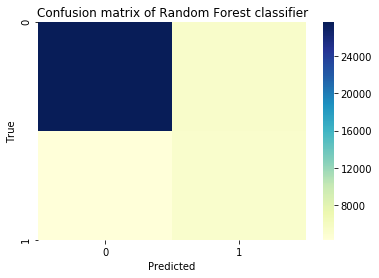

In [33]:
pl_rf = predictions_dt.select(['prediction', 'label']).rdd.map(lambda line:(line[0], line[1]))

# Instantiating the metrics object
metrics_rf = MulticlassMetrics(pl_rf)
confusion_matrix_rf = metrics_rf.confusionMatrix().toArray()
print("Confusion matrix:")
print(confusion_matrix_rf, "\n")
# Overall statistics
print("Overall Statistics")
print("Precision = ", metrics_rf.precision())
print("Recall = ",  metrics_rf.recall())
print("F1 Score = ", metrics_rf.fMeasure())

plt.title('Confusion matrix of Random Forest classifier')
ax = sns.heatmap(confusion_matrix_rf, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Logistic Regression

Confusion matrix:
[[27630.  5428.]
 [ 4260.  5249.]] 

Summary Stats
Precision =  0.7724058543002795
Recall =  0.7724058543002795
F1 Score =  0.7724058543002795


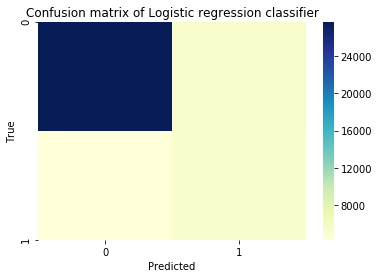

In [34]:
pl_lr = predictions_dt.select(['prediction', 'label']).rdd.map(lambda line:(line[0], line[1]))

# Instantiating the metrics object
metrics_lr = MulticlassMetrics(pl_lr)
confusion_matrix_lr = metrics_lr.confusionMatrix().toArray()
print("Confusion matrix:")
print(confusion_matrix_lr, "\n")
# Overall statistics
print("Summary Stats")
print("Precision = ",  metrics_lr.precision())
print("Recall = ",  metrics_lr.recall())
print("F1 Score = ", metrics_lr.fMeasure())

plt.title('Confusion matrix of Logistic regression classifier')
ax = sns.heatmap(confusion_matrix_lr, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Gradient boosted tree classifier

Confusion matrix:
[[27630.  5428.]
 [ 4260.  5249.]] 

Summary Stats
Precision =  0.7724058543002795
Recall =  0.7724058543002795
F1 Score =  0.7724058543002795


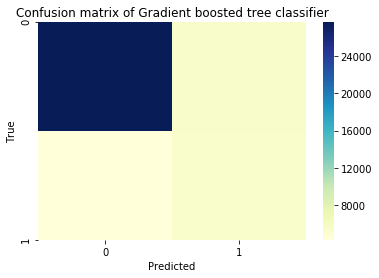

In [35]:
pl_gbt = predictions_dt.select(['prediction', 'label']).rdd.map(lambda line:(line[0], line[1]))

# Instantiating the metrics object
metrics_gbt = MulticlassMetrics(pl_gbt)
confusion_matrix_gbt = metrics_gbt.confusionMatrix().toArray()
print("Confusion matrix:")
print(confusion_matrix_gbt, "\n")
# Overall statistics
print("Summary Stats")
print("Precision = ", metrics_gbt.precision())
print("Recall = ", metrics_gbt.recall())
print("F1 Score = ", metrics_gbt.fMeasure())

plt.title('Confusion matrix of Gradient boosted tree classifier')
ax = sns.heatmap(confusion_matrix_gbt, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The Accuracy of the above predictions can be improved by treating outliers appropriately. It is important to detect the outliers and perform transformation on them so as to reduce their negative impact on the accuracy. Also, finding the optimum value of each parameters(parameter tuning) in each of the above machine learning algorithms can help in improving the accuracy of the predictions. Overall, collecting more weather data also can help in providing better predictions.

References:

Tutorial material

https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html

https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/
